In [1]:
import torch.nn    as nn
import torch.optim as optim
import GM_library  as GML
import numpy       as np
import torch

from os                   import path, listdir
from torch.utils.data     import random_split
from torch_geometric.data import Data

import sys
sys.path.append('../')
import MP.MP_library as MPL

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Define target value to look for
#seeked_target = ##

# Machine-learning parameters
n_epochs      = 1000
batch_size    = 128
learning_rate = 0.0001

# Number of diffusing and denoising steps, which can be different
n_diffusing_steps = 2
n_denoising_steps = 2

# Decay of parameter alpha
noise_contribution = 0.15
alpha_decay = 0.5 * (1 - noise_contribution**2)

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.2
dropout_edge = 0.2

# Define box shape
L = [25, 25, 25]

# Target to generate new crystals
target = 'GM_EPA'

# In case database is created from scratch (otherwise, it is not being used)
DB_path = '../MP/Loaded_EMP'

input_folder    = 'models'
target_folder   = f'{input_folder}/{target}'
edge_model_name = f'{target_folder}/edge_model.pt'
node_model_name = f'{target_folder}/node_model.pt'

# Generation of graph database for training

Load the datasets, already standarized if possible.

In [3]:
labels_name         = f'{target_folder}/labels.pt'
dataset_name        = f'{target_folder}/dataset.pt'
dataset_name_std    = f'{target_folder}/standardized_dataset.pt'
parameters_name_std = f'{target_folder}/standardized_parameters.pt'  # Parameters for rescaling the predictions

if path.exists(dataset_name_std) and path.exists(parameters_name_std) and path.exists(labels_name):
    # Load the standardized dataset, with corresponding labels and parameters
    dataset    = torch.load(dataset_name_std)
    labels     = torch.load(labels_name)
    parameters = torch.load(parameters_name_std)

    # Assigning parameters accordingly
    target_mean, feat_mean, edge_mean, target_std, edge_std, feat_std, scale = parameters
    
    # Defining target factor
    target_factor = target_std / scale

elif path.exists(dataset_name) and path.exists(labels_name):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name)
    labels  = torch.load(labels_name)
    
    # Standardize dataset
    dataset, parameters = GML.standardize_dataset(dataset, labels)
    
    # Save standardized dataset
    torch.save(dataset,    dataset_name_std)
    torch.save(parameters, parameters_name_std)

else:
    # Generate the raw dataset from scratch, and standardize it
    
    # Read all mateials within the database
    materials = listdir(DB_path)[:100]
    
    dataset = []
    labels  = []
    for material in materials:
        try:
            # Try to read the polyforms
            polymorfs = listdir(f'{DB_path}/{material}')
        except:
            continue
        
        print(material)
        for polymorf in polymorfs:
            # Path to folder containing the POSCAR
            path_to_POSCAR = f'{DB_path}/{material}/{polymorf}'
            
            # Check that the folder is valid
            if path.exists(f'{path_to_POSCAR}/POSCAR'):
                print(f'\t{polymorf}')

                # Extract parameters from POSCAR
                cell, composition, concentration, positions = MPL.information_from_VASPfile(path_to_POSCAR,
                                                                                            'POSCAR')

                # Generate POSCAR covering the box
                try:
                    nodes, edges, attributes, _, _, _ = GML.graph_POSCAR_encoding(cell,
                                                                                  composition,
                                                                                  concentration,
                                                                                  positions,
                                                                                  L)
                except:
                    print(f'Error: {material} {polymorf} not loaded')
                    continue

                # Load ground state energy per atom
                gs_energy = float(np.loadtxt(f'{path_to_POSCAR}/EPA'))

                # Construct temporal graph structure
                graph = Data(x=nodes,
                             edge_index=edges,
                             edge_attr=attributes,
                             y=torch.tensor([[gs_energy]], dtype=torch.float)
                            )

                # Append to dataset and labels
                dataset.append(graph)
                labels.append(f'{material}-{polymorf}')
    
    # Standardize dataset
    dataset, parameters = GML.standardize_dataset(dataset, labels)
    
    # Save standardized dataset
    torch.save(dataset,    dataset_name_std)
    torch.save(parameters, parameters_name_std)
    torch.save(labels,     labels_name)

# Definition of train-test datasets

In [4]:
# torch.manual_seed(12345)

# Define the sizes of the train and test sets
train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size

# Use random_split() to generate train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of testing  graphs: {len(test_dataset)}')

Number of training graphs: 97
Number of testing  graphs: 25


# Training of the model

In [5]:
# Determine number of features in dataset
n_features = dataset[0].num_node_features

# Instantiate the models for nodes and edges
node_model = GML.nGCNN(n_features, dropout_node).to(device)
edge_model = GML.eGCNN(n_features, dropout_edge).to(device)
print('\nNode GCNN:')
print(node_model)
print('\nEdge GCNN:')
print(edge_model)


Node GCNN:
nGCNN(
  (conv1): GraphConv(4, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 4)
)

Edge GCNN:
eGCNN(
  (linear1): Linear(in_features=4, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
# Initialize the optimizers
node_optimizer = torch.optim.Adam(node_model.parameters(), lr=learning_rate)
edge_optimizer = torch.optim.Adam(edge_model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
for epoch in range(n_epochs):
    # Initialize train loss variable
    train_loss = 0
    for graph in train_dataset:
        # Initialize the gradient of the optimizers
        node_optimizer.zero_grad()
        edge_optimizer.zero_grad()
        
        # Diffuse the graph with some noise
        #print()
        #print('Diffusing...')
        diffused_graph, _ = GML.diffuse(graph, n_diffusing_steps,
                                        s=alpha_decay)
        
        # Denoise the diffused graph
        #print(f'Denoising...')
        denoised_graph, _ = GML.denoise(diffused_graph, n_denoising_steps, node_model, edge_model,
                                        s=alpha_decay)
        
        # Backpropagation and optimization step
        #print('Backpropagating...')
        
        # Calculate the loss for node features and edge attributes
        node_loss, edge_loss = GML.get_graph_losses(graph, denoised_graph)
        
        # Backpropagate node and edge losses (retained graph, as it is used two times)
        node_loss.backward(retain_graph=True)
        edge_loss.backward(retain_graph=True)
        
        # Perform a single step for each optimized
        node_optimizer.step()
        edge_optimizer.step()
        
        # Predict target for current graph
        #predicted_target = ###
        
        # Compute target loss
        #target_loss = GML.get_target_loss(predicted_target, seeked_target)
        target_loss = 0
                
        # Accumulate the total training loss
        loss = node_loss + edge_loss + target_loss
        train_loss += loss.item()
    
    # Compute the average train loss
    train_loss = train_loss / len(train_dataset)
    train_losses.append(train_loss)
    
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}')

Epoch: 1, Train Loss: 116423151559668512.0000
Epoch: 2, Train Loss: 21848423698103688.0000
Epoch: 3, Train Loss: 9951863218681552.0000
Epoch: 4, Train Loss: 5095197736166453.0000
Epoch: 5, Train Loss: 3464994044960603.0000
Epoch: 6, Train Loss: 2414355622001694.5000
Epoch: 7, Train Loss: 2443733704972748.0000
Epoch: 8, Train Loss: 1532984645642577.2500
Epoch: 9, Train Loss: 1489441179126038.5000
Epoch: 10, Train Loss: 1553783462252656.7500
Epoch: 11, Train Loss: 1086063447827381.0000
Epoch: 12, Train Loss: 1214647229239496.2500
Epoch: 13, Train Loss: 886102847077825.3750
Epoch: 14, Train Loss: 957847636062595.7500
Epoch: 15, Train Loss: 693869130031484.0000
Epoch: 16, Train Loss: 769993312817343.0000
Epoch: 17, Train Loss: 859745293918436.0000
Epoch: 18, Train Loss: 565211304803817.6250
Epoch: 19, Train Loss: 616609184837935.8750
Epoch: 20, Train Loss: 512603750152121.5625
Epoch: 21, Train Loss: 387558424084285.1875
Epoch: 22, Train Loss: 333990960036587.8125
Epoch: 23, Train Loss: 346

Epoch: 190, Train Loss: 3523287439541.6406
Epoch: 191, Train Loss: 2272494581360.4546
Epoch: 192, Train Loss: 1862856861613.6233
Epoch: 193, Train Loss: 1986951694445.3425
Epoch: 194, Train Loss: 3199564181848.8828
Epoch: 195, Train Loss: 373510397718233.6250
Epoch: 196, Train Loss: 248798652988241.5625
Epoch: 197, Train Loss: 213374865096929.5000
Epoch: 198, Train Loss: 125293247137007.6719
Epoch: 199, Train Loss: 75965390936045.8281
Epoch: 200, Train Loss: 30433521031509.0273
Epoch: 201, Train Loss: 60106736651204.8984
Epoch: 202, Train Loss: 36229561080614.4375
Epoch: 203, Train Loss: 27901374479205.6953
Epoch: 204, Train Loss: 14981445346561.5312
Epoch: 205, Train Loss: 8461398773306.7617
Epoch: 206, Train Loss: 6787545825052.5254
Epoch: 207, Train Loss: 5426282646533.0576
Epoch: 208, Train Loss: 4625327207228.0977
Epoch: 209, Train Loss: 4228880066862.1973
Epoch: 210, Train Loss: 3615445294227.3452
Epoch: 211, Train Loss: 2866216553935.1631
Epoch: 212, Train Loss: 2942526340837.95

In [9]:
torch.save(edge_model.state_dict(), edge_model_name)
torch.save(node_model.state_dict(), node_model_name)

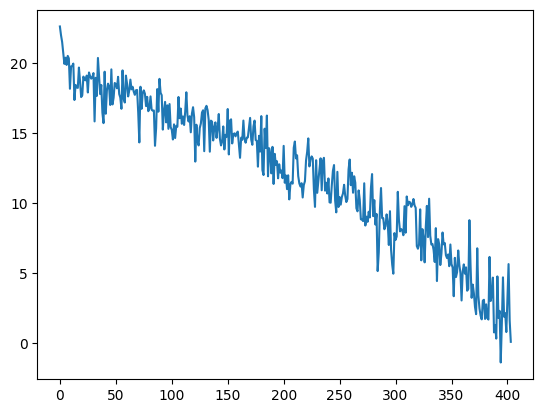

In [8]:
import matplotlib.pyplot as plt
plt.plot(np.log(train_losses))